### 1. Importing libraries

In [2]:
# Libraries for loading of dataset and forming the dataframe
import pandas as pd
import json
import os
import glob

# Libraries for statistical operations
import numpy as np

# Libraries and utilities for Data Preprocessing
from sklearn.preprocessing import LabelEncoder
import joblib

# Libraries and utilities for Decision Tree model and metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Libraries for Data Visualisation
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns


### 2. Loading dataset

In [100]:
# Function for loading the dataset files
def load_files(file_list):
    """
    This function loads and parses JSON data from a list of files.
    Args:
        file_list : A list of file paths to JSON files.
    Returns:
        data_list: A list of JSON objects, where each object 
        represents a corresponding file in 'file_list'.
    """

    # Initialise a list to store data from each file
    data_list = []
    
    # Iterate over the list of files
    for file in file_list:
        with open(file, 'r') as f:
            # Load the JSON data from the file and append it to the data_list
            data_list.append(json.load(f))
    return data_list

In [101]:
def generate_review_id(review):
    """
    This function generates a unique review id from review metadata.
    It is constructed by concatenation of reviewer ID,
    product ASIN, and Unix review timestamp, separated by underscores.
    Args:
        review : A dictionary containing review metadata.
    Returns:
        A string in the format '<reviewerID>_<asin>_<unixReviewTime>'.
    """

    return f"{review.get('reviewerID')}_{review.get('asin')}_{review.get('unixReviewTime')}"


def extract_data(json_data):
    """
    Extracts required fields from each review JSON object.
    
    Args:
        json_data (dict): JSON object containing review data.
        
    Returns:
        dict: Extracted data fields.
    """

    extracted_data = []
    
    for review in json_data:
        
        # Get the current review's helpful votes
        vote = review.get("vote")  

        # Default to zero if vote is missing
        if vote is None:
            vote = 0    
            vote_missing = True 
        else:
            vote = int(vote)
            vote_missing = False

        # Store relevant fields in a dictionary
        review_data = {
            "reviewer_overall_rating": review.get("overall"),
            "verified": review.get("verified", False),
            "image_exists": bool(review.get("imageURL")),
            "reviewer_history": review.get("reviewer_history", []),
            "vote": vote
        }

     
        # Calculate the average helpful votes if reviewer_history exists
        reviewer_history = review.get("reviewer_history", [])
        
        # Convert all values in reviewer_history to integers
        if reviewer_history:
            try:
                reviewer_history = [int(vote) for vote in reviewer_history]
                
                if not vote_missing and vote in reviewer_history:
                    # Exclude the current vote
                    reviewer_history.remove(vote)    
                
                if reviewer_history:
                    # Calculate average helpful votes
                    reviewer_avg_helpful_votes = sum(reviewer_history) / len(reviewer_history)
                else:
                    # Default to 0 if no past history remains
                    reviewer_avg_helpful_votes = 0  

                reviewer_avg_helpful_votes = round(reviewer_avg_helpful_votes, 3)
            
            except ValueError:
                # Default to 0 if conversion fails
                reviewer_avg_helpful_votes = 0  

        else:
            # Default to 0 if no reviewer history exists
            reviewer_avg_helpful_votes = 0  
        
        # Store average votes in the dictionary
        review_data["reviewer_history_avg"] = reviewer_avg_helpful_votes
        
        
        # Extract summary annotations
        if "summary_annotations" in review:
            for key, value in review["summary_annotations"].items():
                if key == "OVERALL":
                    valid_ratings = {k: v for k, v in value.items() if k != "n/a" and v > 0}
                    if valid_ratings:
                        # Get the highest voted value
                        review_data[key] = max(valid_ratings, key=valid_ratings.get)  
                    else:
                        review_data[key] = 'n/a'
                else:
                    # Get the highest voted value
                    review_data[key] = max(value, key=value.get)   
        
        # Generate unique identifier for each review
        review_data["review_id"] = generate_review_id(review)

        extracted_data.append(review_data)
    
    return extracted_data

In [102]:
# Specify the directory where the files are located
review_dir = os.path.join("ML_datasets", "ML_datasets")  

# Get all JSON files in the specified directory
review_files = glob.glob(os.path.join(review_dir, "*.json"))

# Load all files
metadata_list = load_files(review_files)

# Extract data from the loaded files
extracted_data = [extract_data(data) for data in metadata_list]

# Extract categories from filenames
categories = [
    os.path.basename(file).replace("_extended.json", "").replace("_", " ") 
    for file in review_files
]

# Flatten the extracted data list
flattened_data = [item for sublist in extracted_data for item in sublist]

# Convert the extracted data to a DataFrame
df = pd.DataFrame(flattened_data)

# Add category information based on the filename
category_column = [
    category for category, file_data in zip(categories, metadata_list) for _ in range(len(file_data))
]

# Ensure lengths match
if len(category_column) == len(df):
    df["category"] = category_column
else:
    print("Mismatch: category_column length =", len(category_column), "df length =", len(df))

# Rename columns to specify two product ratings - one by reviewer, another by annotator 
df["annotated_overall_product_rating"] = df["OVERALL"]
df = df.drop(columns=["OVERALL"])
df["reviewer_overall_product_rating"] = df["reviewer_overall_rating"]
df=df.drop(columns=["reviewer_overall_rating"])

# Clean and reorder columns
df = df.drop(columns=["reviewer_history"], errors='ignore')
expected_columns = ["category", "verified"]
existing_columns = [col for col in expected_columns if col in df.columns]
other_columns = [col for col in df.columns if col not in expected_columns and col != "vote"]
df = df[existing_columns + other_columns + ["vote"]]
cols = ['review_id'] + [col for col in df.columns if col != 'review_id']
df = df[cols]

# Save DataFrame to a CSV File
# df.to_csv("helpful_votes_with_rating.csv", index=False)


In [103]:
# Check df
df.head()

,review_id,category,verified,image_exists,reviewer_history_avg,Feature Usage,Interaction Time,Context Experience,Efficiency,Excellence,Status,Esteem,Play,Aesthetics,Ethics,Spirituality,Clarity of Sentiment,annotated_overall_product_rating,reviewer_overall_product_rating,vote
0,A5TA1NJOC0PJ5_7414204790_1457568000,All Beauty,True,True,0.000,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,3,4,5.0,0
1,A80M2286B7STE_7414204790_1412294400,All Beauty,True,True,0.000,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,1,1,4,5.0,0
2,A1TJICB7VLGQKL_7414204790_1441065600,All Beauty,True,True,0.000,n/a,n/a,n/a,n/a,4,n/a,n/a,n/a,n/a,n/a,n/a,1,4,5.0,0
3,A2TM2MAA8IT34U_7414204790_1407369600,All Beauty,True,True,0.176,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,1,4,5.0,0
4,AQGWT465GTEJG_7414204790_1402704000,All Beauty,True,True,0.000,n/a,n/a,2,2,n/a,n/a,n/a,n/a,n/a,n/a,n/a,4,2,4.0,2


### 3. Data preprocessing

In [104]:
# Check datatypes
print(df.dtypes)

review_id                            object
category                             object
verified                               bool
image_exists                           bool
reviewer_history_avg                float64
Feature Usage                        object
Interaction Time                     object
Context Experience                   object
Efficiency                           object
Excellence                           object
Status                               object
Esteem                               object
Play                                 object
Aesthetics                           object
Ethics                               object
Spirituality                         object
Clarity of Sentiment                 object
annotated_overall_product_rating     object
reviewer_overall_product_rating     float64
vote                                  int64
dtype: object


#### (3.1) Processing of categorical columns

In [105]:
# Pre-processing 'category' column - assign a numeric value for each category by Label Encoding
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
# Save the encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Pre-processing 'verified' column - assign an integer value for True/False
df['verified'] = df['verified'].astype(int)

# Pre-processing 'image_exists' column - assign an integer value for True/False
df['image_exists'] = df['image_exists'].astype(int)

#### (3.2) Handling of 'n/a' values

In [106]:
# Categorise features for appropriate interpretation of 'n/a' values

# Evidence of experience - 'n/a' here essentially means that there is no evidence of any experience with the associated product from the review
evidence_of_exp = ["Feature Usage", "Interaction Time", "Context Experience"]
# No evidence is marked as the lowest on a scale of 5, so 'n/a' replaced by zero for these features
df[evidence_of_exp] = df[evidence_of_exp].replace("n/a", 0)

# Consumer Values - 'n/a' here implies that a particular value might not be applicable at all to a product and hence not present in the review
consumer_values = ["Excellence", "Efficiency", "Status", "Esteem", "Play", "Aesthetics", "Ethics", "Spirituality"]

# Create a column mentioning whether a value is applicable or not, and replace 'n/a' values by neutral value of 3 (on a scale of 5)
for col in consumer_values:
    df[f"{col}_applicable"] = (df[col] != "n/a").astype(int)  # 1 if applicable, 0 if not
    df[col] = df[col].replace("n/a", 3).astype(int)  # Convert 'n/a' to 3


# Handle 'n/a' values for annotated overall product rating
df["annotated_overall_product_rating"] = df["annotated_overall_product_rating"].replace("n/a", 3).astype(int)
df["annotated_product_rating_applicable"] = (df["annotated_overall_product_rating"] != 3).astype(int)



In [107]:
# Check
df.head()

,review_id,category,verified,image_exists,reviewer_history_avg,Feature Usage,Interaction Time,Context Experience,Efficiency,Excellence,...,vote,Excellence_applicable,Efficiency_applicable,Status_applicable,Esteem_applicable,Play_applicable,Aesthetics_applicable,Ethics_applicable,Spirituality_applicable,annotated_product_rating_applicable
0,A5TA1NJOC0PJ5_7414204790_1457568000,1,1,1,0.000,0,0,0,3,3,...,0,0,0,0,0,0,0,0,0,1
1,A80M2286B7STE_7414204790_1412294400,1,1,1,0.000,0,0,0,3,3,...,0,0,0,0,0,0,0,0,1,1
2,A1TJICB7VLGQKL_7414204790_1441065600,1,1,1,0.000,0,0,0,3,4,...,0,1,0,0,0,0,0,0,0,1
3,A2TM2MAA8IT34U_7414204790_1407369600,1,1,1,0.176,0,0,0,3,3,...,0,0,0,0,0,0,0,0,0,1
4,AQGWT465GTEJG_7414204790_1402704000,1,1,1,0.000,0,0,2,2,3,...,2,0,1,0,0,0,0,0,0,1


### 4. Exploratory data analysis

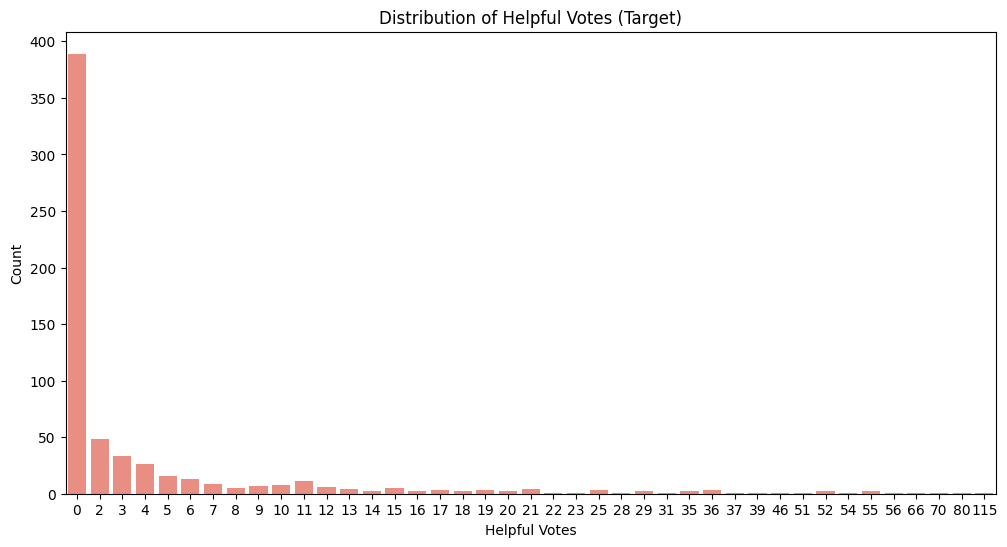

In [108]:
# Plot distribution of target variable 'vote'
plt.figure(figsize=(12, 6))
sns.countplot(x='vote', data=df, color='salmon')
plt.title('Distribution of Helpful Votes (Target)')
plt.xlabel('Helpful Votes')
plt.ylabel('Count')
plt.show()

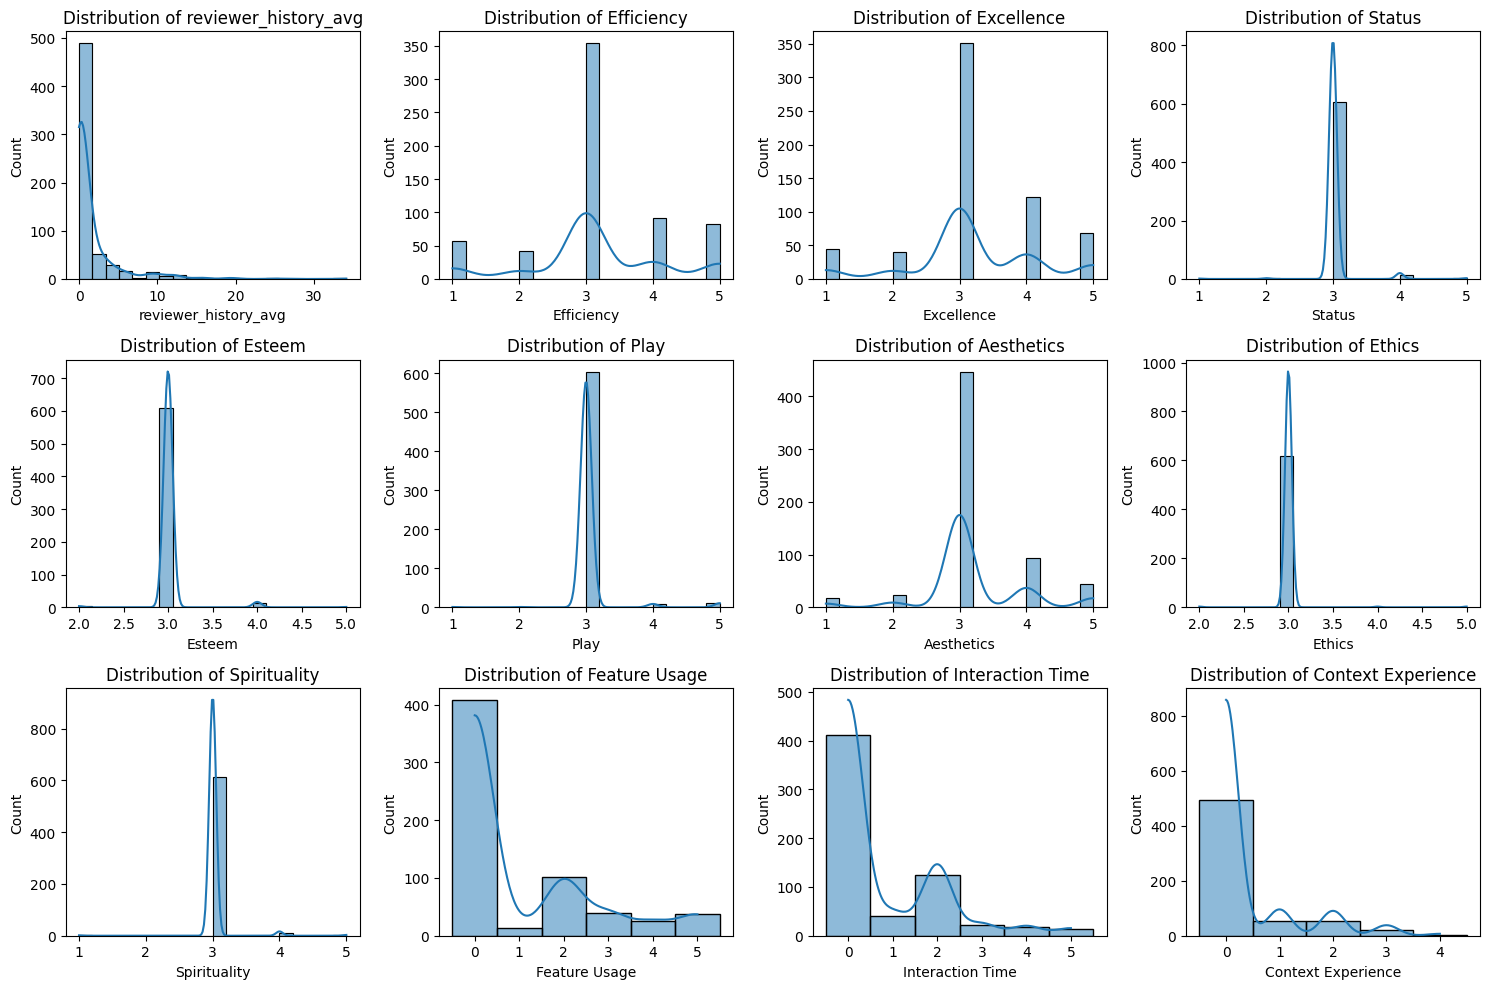

In [109]:
# Numeric columns
numeric_cols = ['reviewer_history_avg', 'Efficiency', 'Excellence', 'Status', 'Esteem', 'Play', 
                'Aesthetics', 'Ethics', 'Spirituality', 'Feature Usage', 'Interaction Time', 'Context Experience']

# Plot histogram
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    # Create subplots in 3 rows, 4 columns
    plt.subplot(3, 4, i)  
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

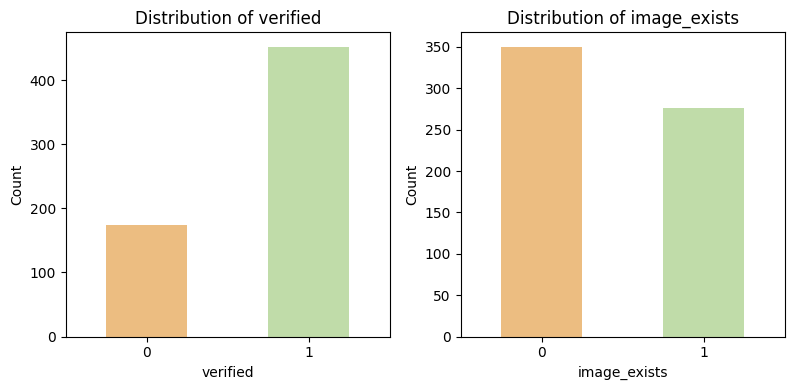

In [110]:
# Categorical columns
categorical_cols = ['verified', 'image_exists']

# Plot
plt.figure(figsize=(12, 4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=col, data=df, width=0.5, hue=col, palette='Spectral', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 5. Implementing Decision Tree Regressor Model

In [111]:
def run_decision_tree_regressor(X,y):
    """
    This function splits dataset into training and testing sets,
    performs cross-validation on the training data, trains a
    DecisionTreeRegressor, evaluates its performance on both the
    training and test sets, computes feature importances, and 
    visualises top levels of the trained decision tree.

    Args:
        X : pandas.DataFrame
            Feature matrix containing the input variables. Column names
            are used for feature importance and tree visualisation.
        y : array-like
            Target variable corresponding to the regression task.

    Returns:
        cv_mae_scores : numpy.ndarray
                Cross-validated Mean Absolute Error (MAE) scores computed on the training set.
        mae_dtr : float
                Mean Absolute Error (MAE) of the trained model on the test set.
        rmse_dtr : float
                Root Mean Squared Error (RMSE) of the trained model on the test set.

    """

    # Split dataset into train and test sets in 80:20 ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialise model
    dtr = DecisionTreeRegressor(max_depth=None, min_samples_split=15, random_state=42)

    # Cross Validation
    cv_scores = cross_val_score(dtr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mae_scores = -cv_scores
    print(f"Cross-validated MAE scores: {cv_mae_scores}")
    print(f"Average CV MAE: {cv_mae_scores.mean()}")

    # Train the model
    dtr.fit(X_train, y_train)

    # Training Performance
    y_train_pred = dtr.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    print(f"Training MAE: {train_mae}")
    print(f"Training RMSE: {train_rmse}")

    # Evaluate on Test Set
    y_pred_dtr = dtr.predict(X_test)
    mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
    rmse_dtr = np.sqrt(mean_squared_error(y_test, y_pred_dtr))
    print(f" Test Set Mean Absolute Error: {mae_dtr}")
    print(f"Test Set RMSE: {rmse_dtr}")

    # Feature Importance
    feature_importance = pd.Series(dtr.feature_importances_, index=X.columns)
    print("\nFeature Importance:\n", feature_importance.sort_values(ascending=False))

    # Optional: Export feature importances to Excel 
    # feature_importance_df = feature_importance.sort_values(ascending=False).reset_index()
    # feature_importance_df.columns = ['Feature', 'Importance']
    # feature_importance_df.to_excel('feature_importances.xlsx', index=False)

    # Plot Tree
    plt.figure(figsize=(20,10))
    plot_tree(dtr, feature_names=X.columns, filled=True, rounded=True, fontsize=14, max_depth=2)
    plt.show()


    return cv_mae_scores, mae_dtr, rmse_dtr

In [112]:
# Log transform target variable to handle zero values and extremities
df["vote_log"] = np.log1p(df["vote"])  

# Drop original target, ID, and category columns
X = df.drop(columns=["vote", "vote_log", "review_id", "category"])  

# Use log-transformed target
y = df["vote_log"]  

#### (5.1) Base Model Run

Cross-validated MAE scores: [0.69601586 0.74197036 0.66712156 0.75624909 0.6785505 ]
Average CV MAE: 0.7079814730747171
Training MAE: 0.4305408752857334
Training RMSE: 0.6543823768175304
 Test Set Mean Absolute Error: 0.7529092787656089
Test Set RMSE: 1.1871646861349436

Feature Importance:
 reviewer_history_avg                   0.344343
Context Experience                     0.114195
annotated_overall_product_rating       0.105654
verified                               0.096949
Aesthetics                             0.078986
reviewer_overall_product_rating        0.054320
Excellence                             0.045240
Clarity of Sentiment                   0.039703
Efficiency                             0.033105
Interaction Time                       0.017008
Excellence_applicable                  0.015762
Esteem_applicable                      0.012312
image_exists                           0.010610
Play                                   0.009994
Esteem                             

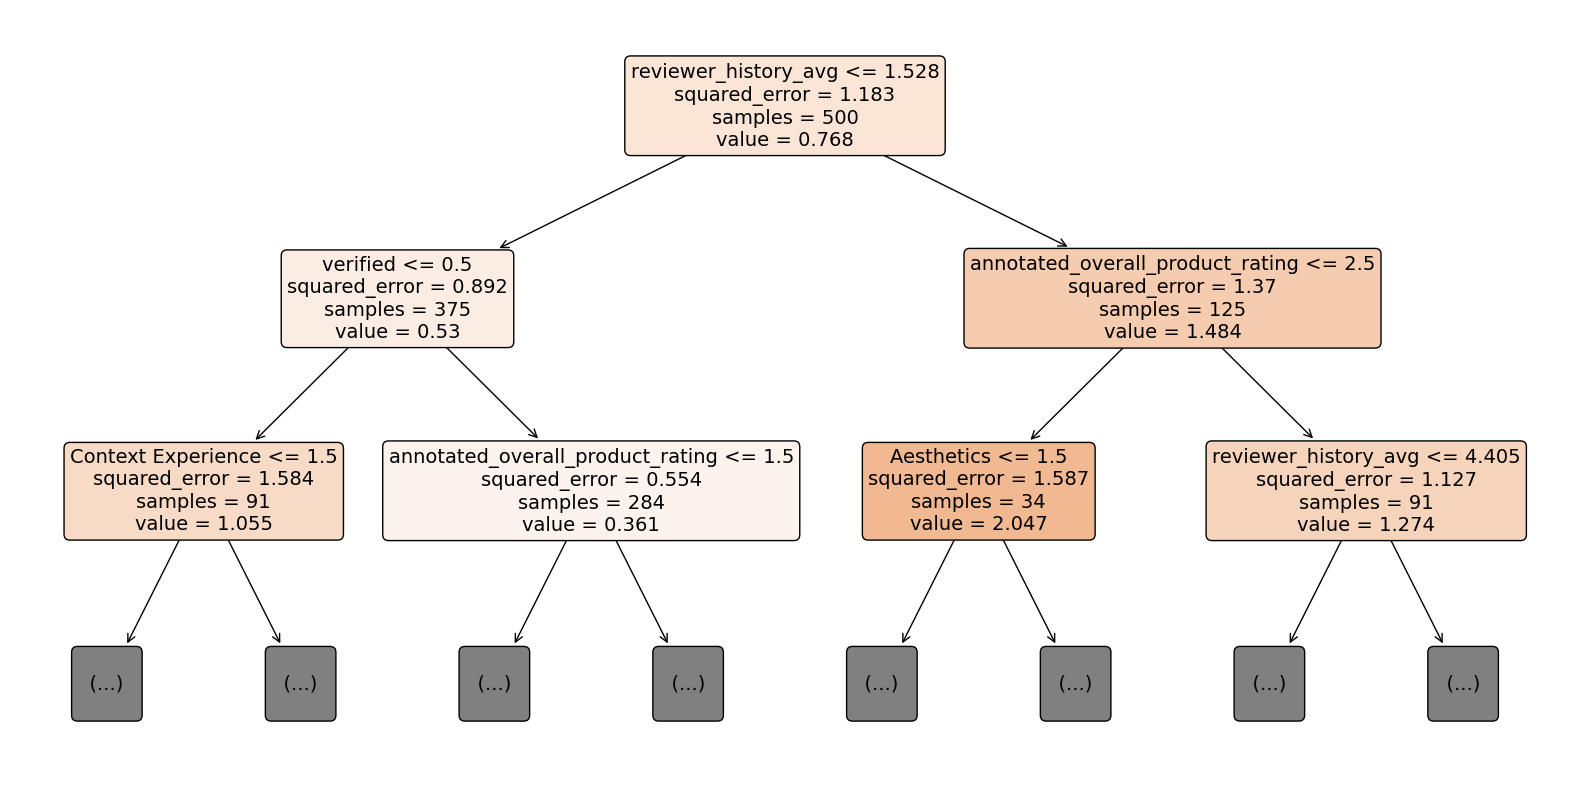

In [113]:
# Run decision tree regressor
cv_mae_scores, mae_dtr, rmse_dtr = run_decision_tree_regressor(X,y)

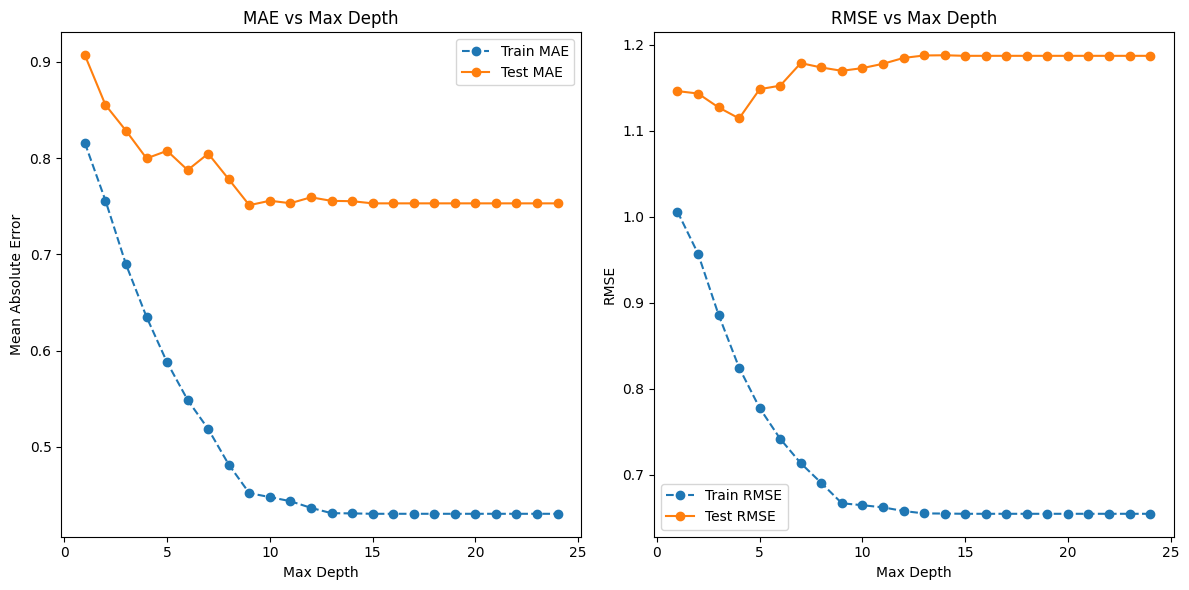

In [114]:
# Plot MAE and RMSE v/s max_depth to check model performance and stability

max_depth_range = range(1, 25) 
mae_train = []
mae_test = []
rmse_train = []
rmse_test = []
feature_importances = []

# Iterate over different values of max_depth
for max_depth in max_depth_range:
    # Train the Decision Tree with the given max_depth
    dtr = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=15, random_state=42)
    dtr.fit(X_train, y_train)
    
    # Predictions for train and test
    y_train_pred = dtr.predict(X_train)
    y_test_pred = dtr.predict(X_test)
    
    # Calculate MAE and RMSE for training and test sets
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))
    
    rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    

# Plot MAE and RMSE for train and test
plt.figure(figsize=(12, 6))

# MAE vs max_depth subplot
plt.subplot(1, 2, 1)
plt.plot(max_depth_range, mae_train, label='Train MAE', marker='o', linestyle='--')
plt.plot(max_depth_range, mae_test, label='Test MAE', marker='o', linestyle='-')
plt.xlabel('Max Depth')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Max Depth')
plt.legend()

# RMSE vs max_depth subplot
plt.subplot(1, 2, 2)
plt.plot(max_depth_range, rmse_train, label='Train RMSE', marker='o', linestyle='--')
plt.plot(max_depth_range, rmse_test, label='Test RMSE', marker='o', linestyle='-')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs Max Depth')
plt.legend()

plt.tight_layout()
plt.show()


#### (5.2) Ablation Analysis


Cross-validated MAE scores: [0.86125162 0.81669316 0.89420171 0.77125276 0.80702261]
Average CV MAE: 0.8300843723134106
Training MAE: 0.5058568718608834
Training RMSE: 0.738511848652464
 Test Set Mean Absolute Error: 0.8152534450428324
Test Set RMSE: 1.1782454385206322

Feature Importance:
 verified                               0.213133
reviewer_overall_product_rating        0.114251
Context Experience                     0.113620
Feature Usage                          0.094582
annotated_overall_product_rating       0.087175
Efficiency                             0.065934
Clarity of Sentiment                   0.063910
Excellence                             0.042171
Aesthetics                             0.035649
image_exists                           0.033584
Efficiency_applicable                  0.026249
Interaction Time                       0.024258
Excellence_applicable                  0.018994
Esteem_applicable                      0.016927
Aesthetics_applicable               

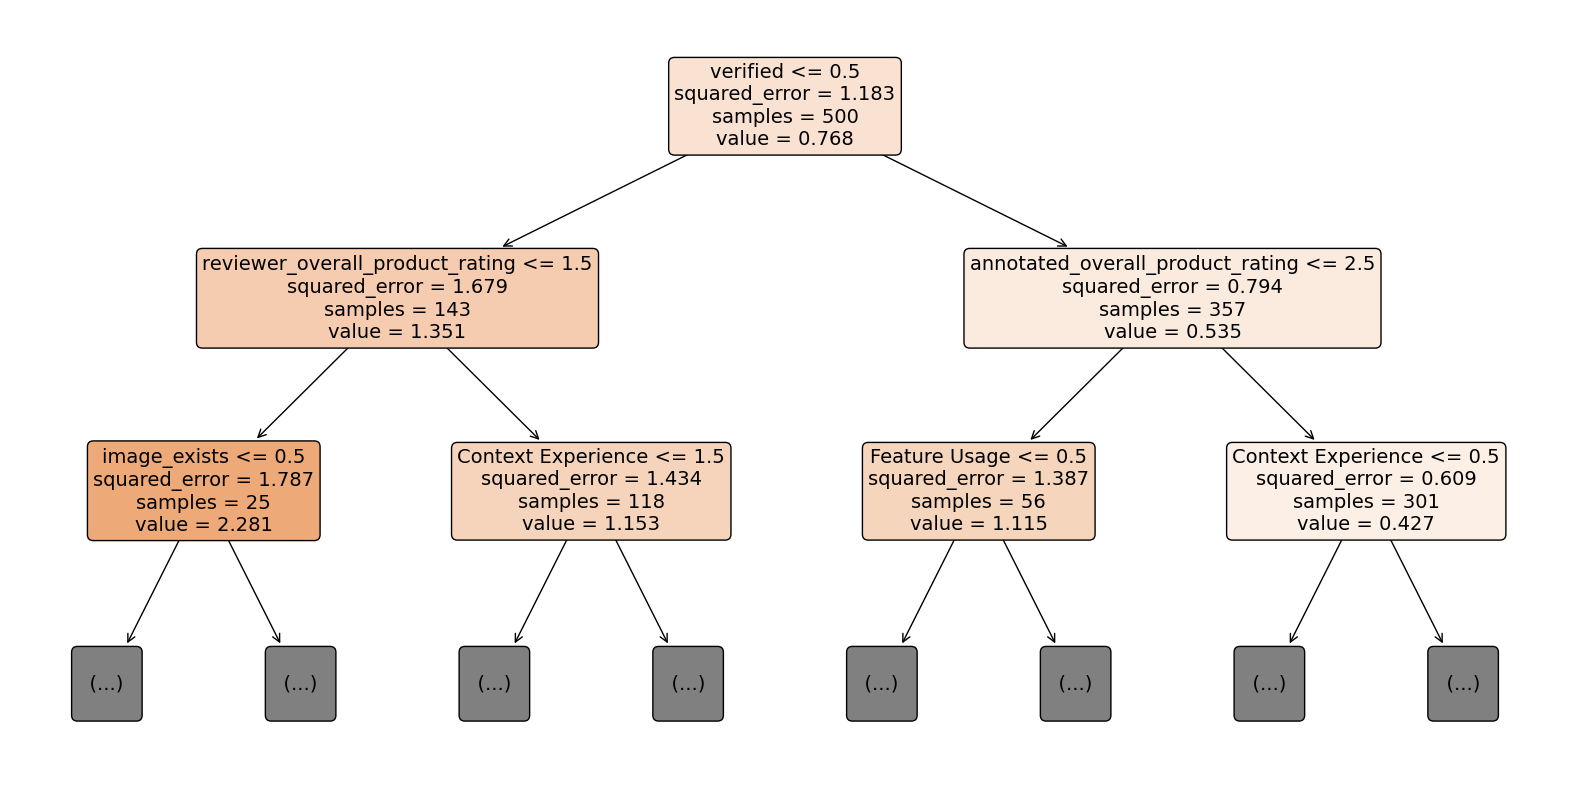

In [115]:
# Drop the most impactful feature - 'reviewer_history_avg' for ablation analysis
X_ablation = df.drop(columns=["reviewer_history_avg", "vote", "vote_log", "review_id", "category"])
y_ablation = df["vote_log"]  # Use log-transformed target

# Run decision tree regressor
cv_mae_scores_abl, mae_dtr_abl, rmse_dtr_abl = run_decision_tree_regressor(X_ablation, y_ablation)

#### (5.3) Ablation Further - Core Variable Set (Removing 'verified' and 'image_exists' for analysis of exact annotated feature set)

Cross-validated MAE scores: [0.87119515 0.87378646 0.96878929 0.8069582  0.84024172]
Average CV MAE: 0.8721941628786448
Training MAE: 0.577737625631892
Training RMSE: 0.8147135707865552
 Test Set Mean Absolute Error: 0.9023800905625248
Test Set RMSE: 1.262926934507484

Feature Importance:
 Efficiency                 0.218164
Feature Usage              0.125136
Context Experience         0.122125
Excellence                 0.121140
Interaction Time           0.083528
Efficiency_applicable      0.059224
Aesthetics                 0.058303
Excellence_applicable      0.044050
Clarity of Sentiment       0.036272
Esteem_applicable          0.028580
Aesthetics_applicable      0.026854
Ethics                     0.022317
Spirituality               0.014881
Ethics_applicable          0.013960
Play                       0.013401
Esteem                     0.004751
Status                     0.004442
Status_applicable          0.002873
Play_applicable            0.000000
Spirituality_applicable  

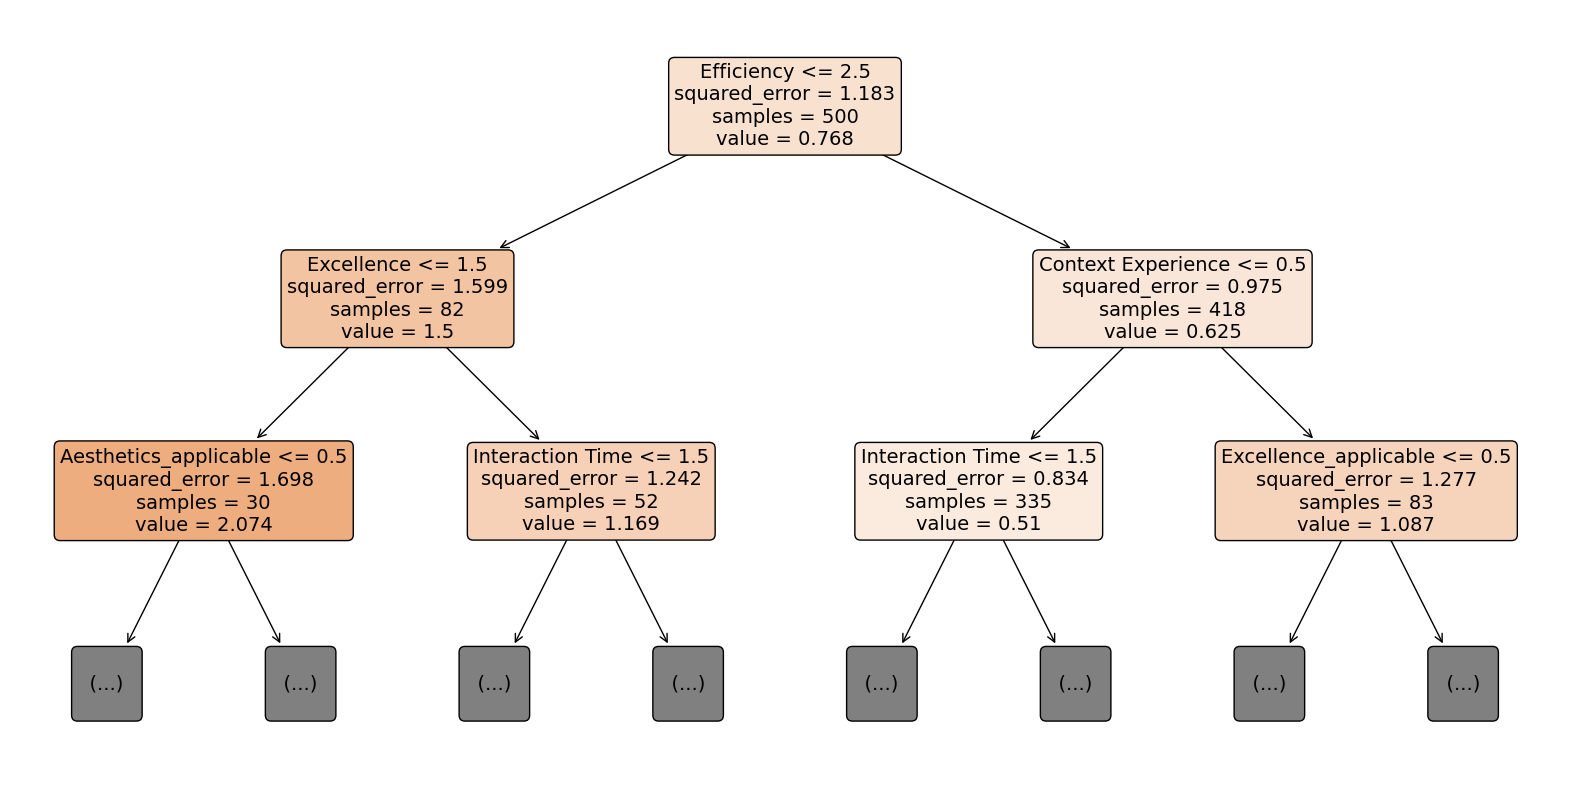

In [116]:
# Drop the two features - 'verified' and 'image_exists' in addition to 'reviewer_history_avg' being already dropped for ablation analysis
X_ablation_extended = df.drop(columns=["reviewer_history_avg", "verified", "image_exists", "reviewer_overall_product_rating", "annotated_overall_product_rating",
                                        "annotated_product_rating_applicable", "vote", "vote_log", "review_id", "category"])
y_ablation_extended = df["vote_log"]  # Use log-transformed target

# Run decision tree regressor
cv_mae_scores_abl_ext, mae_dtr_abl_ext, rmse_dtr_abl_ext = run_decision_tree_regressor(X_ablation_extended, y_ablation_extended)

### 6. Comparison of results

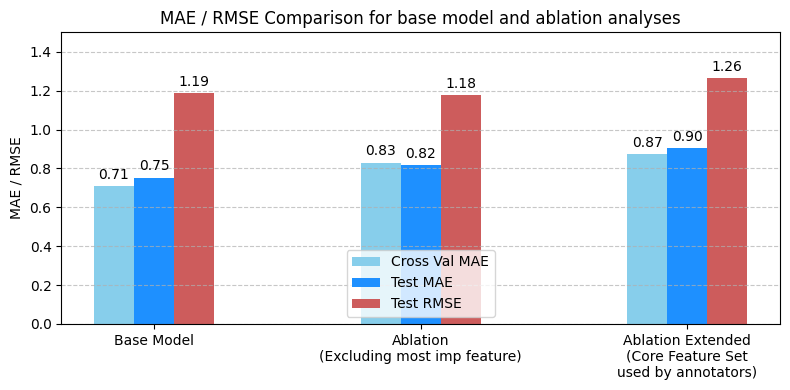

In [117]:
# Compare metrics for the base model, ablation, and extended ablation
models = ['Base Model', 'Ablation\n(Excluding most imp feature)', 'Ablation Extended\n(Core Feature Set\nused by annotators)']
x = np.arange(len(models))
width = 0.15

# Metrics: Cross validation MAE, test MAE, test RMSE
cv_mae_avg = [cv_mae_scores.mean(), cv_mae_scores_abl.mean(), cv_mae_scores_abl_ext.mean()]
test_mae = [mae_dtr, mae_dtr_abl, mae_dtr_abl_ext]
test_rmse = [rmse_dtr, rmse_dtr_abl, rmse_dtr_abl_ext]

# Set figure
fig, ax = plt.subplots(figsize=(8, 4))

# Bar plots
bars1 = ax.bar(x - width, cv_mae_avg, width, label='Cross Val MAE', color='skyblue')
bars2 = ax.bar(x, test_mae, width, label='Test MAE', color='dodgerblue')
bars3 = ax.bar(x + width, test_rmse, width, label='Test RMSE', color='indianred')

# Labels and formatting
ax.set_ylabel('MAE / RMSE')
ax.set_title('MAE / RMSE Comparison for base model and ablation analyses')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.5)
ax.legend(loc='lower center')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()